## Train and Evaluate 2D-Convolutional Neural Network

In [1]:
import keras
import pandas as pd
from glob import glob
import os
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

preprocess_path = "../preprocess/512/"
train_files = glob(os.path.join(preprocess_path, "train/*jpeg"))

df = pd.read_csv("../inputs/trainLabels.csv"))

Using CNTK backend


35126

### CNTK and Keras

If you'd like to use CNTK as Keras backend, don't forget to set the environment variable:

    export KERAS_BACKEND=cntk
    
or update the Keras configuration file:

    {
        "epsilon": 1e-07, 
        "image_data_format": "channels_last", 
        "backend": "cntk", 
        "floatx": "float32" 
    }

Note that you don't need to change the Keras frontend codes for other backends (tensorflow or theano).

Please be aware that CNTK Keras support is in beta and there're known issues. Check the [page](https://docs.microsoft.com/en-us/cognitive-toolkit/Using-CNTK-with-Keras) and the issue tracker on GitHub.

### Image augmentation

Since deep learning models are very flexible, we need large datasets to avoid overfitting. In this example, we randomly rotate, flip and scale the images, and create extra images virtually. This data augmentation technique allows the model to learn invariance to these random transformations.

https://github.com/aleju/imgaug

In [2]:
import imgaug as ia
from imgaug import augmenters as iaa

seq = iaa.Sequential(
    [
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Affine(
            scale=(0.9, 1.1),
            rotate=(-180, 180), # rotate by -180 to +180 degrees
        ),
    ],
    random_order=True
)

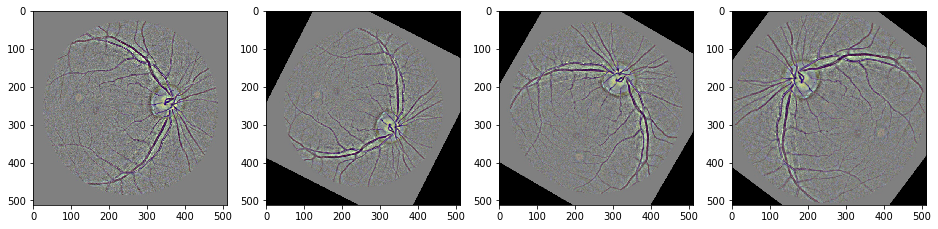

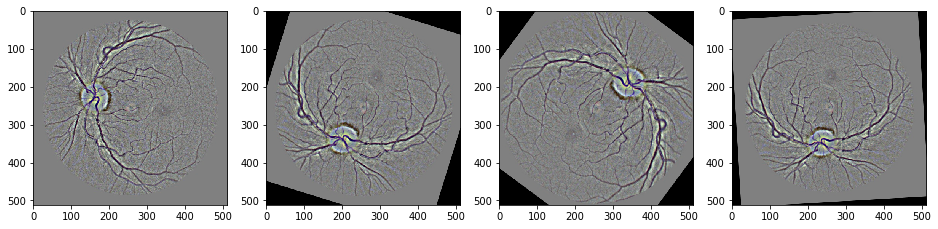

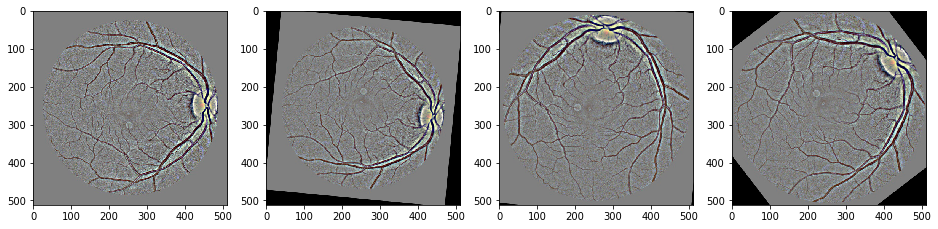

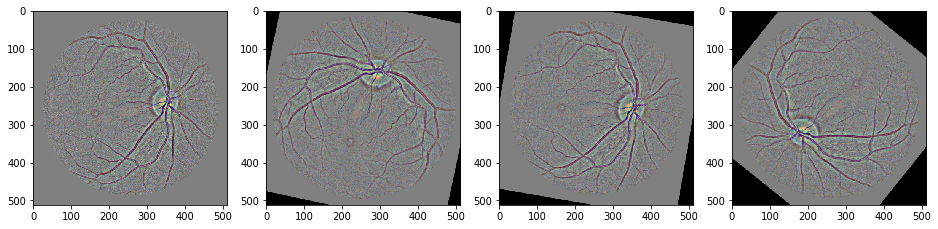

In [3]:
def show_augmented_images(img_file):
    img = cv2.imread(img_file)
    imgs = [img] + seq.augment_images([img for x in range(7)])

    plt.figure(figsize=(16, 6))
    for i in range(0, 4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(imgs[i])
        
show_augmented_images(train_files[0])
show_augmented_images(train_files[1])
show_augmented_images(train_files[2])
show_augmented_images(train_files[3])

### Define Data Sequence

> The generator is run in parallel to the model, for efficiency. For instance, this allows you to do real-time data augmentation on images on CPU in parallel to training your model on GPU.

In [4]:
def get_level(file, df):
    basename = os.path.basename(file)
    image_id = basename.split(".")[0]

    mini_df = df[df['image'] == image_id]
    if len(mini_df) < 1:
        return None

    return mini_df.values[0][1]

# Example: 1 -> [0, 1, 0, 0, 0]
def get_onehot(level):
    level_vec = np.zeros(5)
    level_vec[level] = 1
    
    return level_vec

In [6]:
from keras.utils.data_utils import Sequence

class DataSequence(Sequence):
    def __init__(self, file_list, batch_size, augment=False):
        self.file_list = file_list
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return len(self.file_list) // self.batch_size

    def __getitem__(self, idx):
        imgs = []
        labels = []
        
        i = idx * self.batch_size
        
        while len(imgs) < self.batch_size:
            file = self.file_list[i]
            
            level = get_level(file, df)
            if level is None:
                print("missing level: " + file)
                i += 1
                continue
            
            img = cv2.imread(file)
            
            if img is not None:
                imgs.append(img)
                labels.append(get_onehot(level))
                class_weights = get_class_weights(current_epoch)

            i += 1

        # Image augmentation
        if self.augment:
            imgs = seq.augment_images(imgs)

        return np.asarray(imgs).astype(np.float16), np.asarray(labels).astype(np.int8)

### Define model

In [7]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from datetime import datetime as dt
def get_experiment_id():
    time_str = dt.now().strftime('%Y-%m-%d-%H-%M-%S')
    experiment_id = 'base_{}'.format(time_str)

    return experiment_id

def get_model(input_dim):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(input_dim, input_dim, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96, (3, 3), activation='relu'))
    model.add(Conv2D(96, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(192, (3, 3), activation='relu'))
    model.add(Conv2D(192, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.003, momentum=0.9, nesterov=True), metrics=['accuracy'])

    return model

In [8]:
model = get_model(512)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 510, 510, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 508, 508, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 254, 254, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 252, 252, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 250, 250, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 123, 123, 96)      55392     
__________

### Training 2D-2D-Convolutional Neural Network

In [9]:
train_files = glob(os.path.join(preprocess_path, "train/*jpeg"))

n_val_files = len(train_files) // 10

val_file_list = train_files[:n_val_files]
train_file_list = train_files[n_val_files:]

In [10]:
batch_size = 16

train_gen = DataSequence(train_file_list, batch_size, augment=True)
validate_gen = DataSequence(val_file_list, batch_size, augment=True)

model = get_model(512)

experiment_id = get_experiment_id()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint(experiment_id + "-val_loss_checkpoint.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=1e-6)
]

history = model.fit_generator(generator=train_gen, 
                              validation_data=validate_gen,
                              steps_per_epoch=len(train_gen),
                              validation_steps=len(validate_gen),
                              verbose=1,
                              epochs=125,
                              callbacks=callbacks,
                              workers=7, # recommend: number of cpu cores
                              use_multiprocessing=True)

Epoch 1/125
1421/1421 [==============================] - 1033s - loss: 0.8555 - acc: 0.7434 - val_loss: 0.8446 - val_acc: 0.7396
Epoch 2/125
1421/1421 [==============================] - 1024s - loss: 0.8407 - acc: 0.7445 - val_loss: 0.8431 - val_acc: 0.7396
Epoch 3/125
1421/1421 [==============================] - 1024s - loss: 0.8385 - acc: 0.7445 - val_loss: 0.8395 - val_acc: 0.7396
Epoch 4/125
1421/1421 [==============================] - 1025s - loss: 0.8346 - acc: 0.7445 - val_loss: 0.8335 - val_acc: 0.7396
Epoch 5/125
1421/1421 [==============================] - 1025s - loss: 0.8300 - acc: 0.7445 - val_loss: 0.8303 - val_acc: 0.7396
Epoch 6/125
1421/1421 [==============================] - 1026s - loss: 0.8264 - acc: 0.7445 - val_loss: 0.8238 - val_acc: 0.7396
Epoch 7/125
1421/1421 [==============================] - 1027s - loss: 0.8251 - acc: 0.7445 - val_loss: 0.8238 - val_acc: 0.7396
Epoch 8/125
1421/1421 [==============================] - 1026s - loss: 0.8223 - acc: 0.7445 - val

1421/1421 [==============================] - 1033s - loss: 0.5741 - acc: 0.8139 - val_loss: 0.5756 - val_acc: 0.8121
Epoch 28/125
1421/1421 [==============================] - 1034s - loss: 0.5679 - acc: 0.8153 - val_loss: 0.5755 - val_acc: 0.8129
Epoch 29/125
1421/1421 [==============================] - 1028s - loss: 0.5658 - acc: 0.8171 - val_loss: 0.5700 - val_acc: 0.8125
Epoch 30/125
1421/1421 [==============================] - 1024s - loss: 0.5650 - acc: 0.8158 - val_loss: 0.5638 - val_acc: 0.8217
Epoch 31/125
1421/1421 [==============================] - 1024s - loss: 0.5626 - acc: 0.8189 - val_loss: 0.5920 - val_acc: 0.8033
Epoch 32/125
1421/1421 [==============================] - 1025s - loss: 0.5589 - acc: 0.8173 - val_loss: 0.5559 - val_acc: 0.8232
Epoch 33/125
1421/1421 [==============================] - 1025s - loss: 0.5586 - acc: 0.8193 - val_loss: 0.5712 - val_acc: 0.8153
Epoch 34/125
1421/1421 [==============================] - 1025s - loss: 0.5514 - acc: 0.8200 - val_loss

1421/1421 [==============================] - 1027s - loss: 0.4454 - acc: 0.8538 - val_loss: 0.4727 - val_acc: 0.8487
Epoch 85/125
1421/1421 [==============================] - 1025s - loss: 0.4470 - acc: 0.8535 - val_loss: 0.4721 - val_acc: 0.8467
Epoch 86/125
1420/1421 [============================>.] - ETA: 0s - loss: 0.4473 - acc: 0.8525Epoch 00085: val_loss improved from 0.47153 to 0.46995, saving model to base_2017-07-04-12-44-36-val_loss_checkpoint.hdf5

Epoch 00085: reducing learning rate to 4.6875000407453626e-05.
1421/1421 [==============================] - 1027s - loss: 0.4472 - acc: 0.8525 - val_loss: 0.4700 - val_acc: 0.8499
Epoch 87/125
1421/1421 [==============================] - 1028s - loss: 0.4439 - acc: 0.8528 - val_loss: 0.4697 - val_acc: 0.8467
Epoch 88/125
1421/1421 [==============================] - 1028s - loss: 0.4436 - acc: 0.8544 - val_loss: 0.4730 - val_acc: 0.8463
Epoch 89/125
1421/1421 [==============================] - 1030s - loss: 0.4439 - acc: 0.8536 - v

### Save the final model

In [ ]:
model.save(experiment_id + "_final_model.hdf5")

### Learning Curve

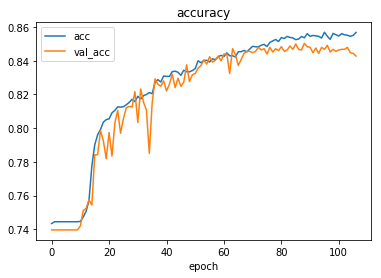

In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

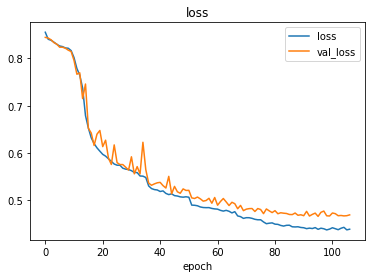

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

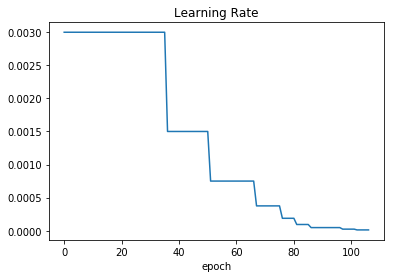

In [13]:
plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.xlabel('epoch')
plt.show()

## Confusion Matrix

> Each column of the matrix represents the instances in a predicted class while each row represents the instances in an actual class (or vice versa).

The lower left cells show the number of samples that the model predicted less severe than the ground truth. For example, the ground truth class was 4 (PDR), but the model predicted as 0 (Normal). In the medical application, we cannot tolerate the errors of this type. Overlooking patients with severe condition may lead to serious consequences.

https://en.wikipedia.org/wiki/Confusion_matrix

### Predict the DR severity using the trained model

Convert one-hot encofing to interger scale (0-4)

In [14]:
y_pred = model.predict_generator(validate_gen, len(validate_gen))
y_pred = np.argmax(y_pred, axis=1)

### Get the ground truth labels

In [45]:
def flatten_list(l):
    return [item for sublist in l for item in sublist]

y_true = flatten_list([np.argmax(y_true, axis=1) for x, y_true in validate_gen])

import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

confusion_table = confusion_matrix(y_true, y_pred)
confusion_table

array([[1812,   18,   27,    0,    1],
       [ 107,   32,   32,    0,    0],
       [  96,   20,  263,    8,    4],
       [   2,    0,   36,   16,    2],
       [   5,    0,   14,    1,   16]])

### Plot the confusion matrix

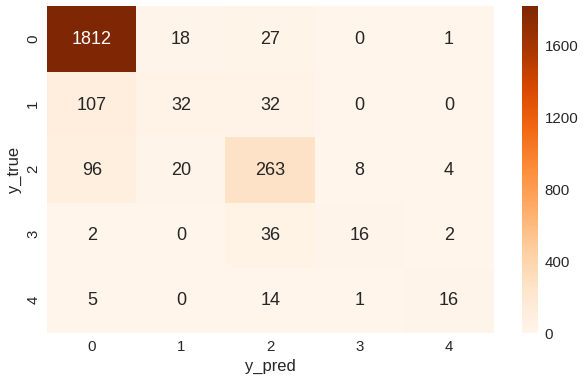

In [28]:
df_cmx = pd.DataFrame(confusion_table, index=[0, 1, 2, 3, 4], columns=[0, 1, 2, 3, 4])

plt.figure(figsize = (10,6))
sn.set(font_scale=1.5)
ax = sn.heatmap(df_cmx, annot=True, cmap='Oranges', fmt='g')
ax.set_ylabel('y_true')
ax.set_xlabel('y_pred')
plt.show()

### Normalized confusion matrix

The percentage of correct answers in the same classe. The underlying data is the same as above, but the normalization helps to see the model accuracy per class.

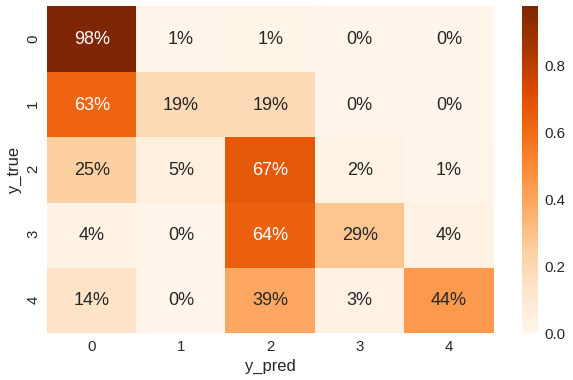

In [43]:
normalized_cf_matrix= confusion_table / confusion_table.sum(axis=1, keepdims=True)
df_cmx = pd.DataFrame(normalized_cf_matrix, index=[0, 1, 2, 3, 4], columns=[0, 1, 2, 3, 4])
plt.figure(figsize = (10,6))
sn.set(font_scale=1.5)
ax = sn.heatmap(df_cmx, annot=True, cmap='Oranges', fmt='.0%')
ax.set_ylabel('y_true')
ax.set_xlabel('y_pred')
plt.show()

# Ideas for improvements

As mentioned above, we need to reduce the misclassifications in the lower-left part of the confusion matrix. One of the causes is the class imbalance in the training set. For the class imbalance problem, we could do:

- Resampling
    - Oversample the examples from the rare classes
- Weighted loss function
    - Add penalty terms for rare classes and severe classes
- Create '0 vs others (1,2,3,4)' classifier
    - By gathering 1-4 classes, we can mitigate the imbalance against class 0. Then, create another classifier for others (1,2,3,4).

Other ideas to consider:
- Model averaging
- Test time data augmentation
- Add Dropout layer